# GANS - Introduction
This notebook is based on the presented ideas from https://www.tensorflow.org/tutorials/generative/dcgan .

In [1]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import os
import PIL
from IPython import display

# custom module
import utils as ut

In [18]:
from importlib import reload
reload(ut)

<module 'utils' from '/home/ec2-user/Programs/gans-learning/utils.py'>

### Load MNIST data
Here we load the data and store it as a tensorflow dataset object: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [2]:
data = tf.keras.datasets.mnist.load_data()

In [3]:
X_train, y_train = data[0]
X_test, y_test = data[1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
# normalize and create tf datasets
X_train_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train/255.,-1)))
X_test_dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_test/255.,-1)))

y_train_dataset = tf.data.Dataset.from_tensor_slices(ut.keras.backend.one_hot(y_train, num_classes=10))
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

In [6]:
for i, element in enumerate(X_test_dataset):
    print(element.numpy().shape)
    if i > 0:
        break

(28, 28, 1)
(28, 28, 1)


In [35]:
iterator = iter(X_train_dataset)
print(next(iterator).numpy().shape)

(28, 28, 1)


### Custom CNN
Let's build a simple CNN which can classify the images.
The goal is not to use all built-in stuff, but to do the learning iteration *by hand*.

In [11]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
STEPS_PER_EPOCH = np.ceil(len(y_train)/BATCH_SIZE)
CHANNELS = 1

In [12]:
# cnn model
img_inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

x = layers.Conv2D(filters=32, kernel_size=(4,4), input_shape=(28,28,1),
                  activation="relu")(img_inputs)

x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=(2,2),
                 activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=10, activation="softmax")(x)

disc_model = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='mnist_model')

In [13]:
disc_model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4128      
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               

### a) train simply

In [14]:
disc_model.compile(loss=ut.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [42]:
history = disc_model.fit(train_dataset.batch(BATCH_SIZE),
                         epochs=5)

Train for 235 steps
Epoch 1/5
235/235 [==============================] - 12s 51ms/step - loss: 1.7145 - accuracy: 0.7696
Epoch 2/5
235/235 [==============================] - 11s 49ms/step - loss: 1.6079 - accuracy: 0.8571
Epoch 3/5
235/235 [==============================] - 12s 49ms/step - loss: 1.5903 - accuracy: 0.8728
Epoch 4/5
235/235 [==============================] - 12s 50ms/step - loss: 1.5125 - accuracy: 0.9532
Epoch 5/5
235/235 [==============================] - 12s 49ms/step - loss: 1.4945 - accuracy: 0.9693


### b) train custom

In [19]:
discriminator_optimizer = tf.keras.optimizers.RMSprop()

In [20]:
custom_training = ut.CustomTraining(model=disc_model,
                                    optimizer=discriminator_optimizer,
                                   loss = ut.losses.CategoricalCrossentropy(from_logits=True))

In [22]:
custom_training.fit(X=X_train_dataset,
                    y=y_train_dataset,
                    each=1, model_params=False, epochs=5)

epoch:  0
loss:  0.0016097287133595816
epoch:  1
loss:  0.001589299995506501
epoch:  2
loss:  0.0015842452862473919
epoch:  3
loss:  0.0015813136303988863
epoch:  4
loss:  0.0015793433472678484


In [25]:
y_pred = custom_training.model.predict(X_test_dataset.batch(32))

In [28]:
y_test_oh = tf.keras.backend.one_hot(y_test, num_classes=10)

In [34]:
y_pred_cast = np.argmax(y_pred, axis=1)

In [35]:
tf.keras.metrics.categorical_accuracy(y_test, y_pred_cast)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [39]:
y_pred_cast[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [40]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

### CNN Discriminator

In [41]:
# final shape: batch size, rows, cols, channel
img_inputs = tf.keras.Input(shape=(28,28,1), batch_size=BATCH_SIZE)

In [42]:
img_inputs.get_shape()

TensorShape([256, 28, 28, 1])

In [48]:
# cnn model
img_inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

x = layers.Conv2D(filters=32, kernel_size=(4,4), input_shape=(28,28,1),
                  activation="relu")(img_inputs)

x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=32, kernel_size=(2,2),
                 activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.MaxPool2D(pool_size=(2,2))(x)
x = layers.Flatten()(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)

disc = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='disc')

In [49]:
disc.summary()

Model: "disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0      

### Generator Architecture
Needs to generate an image out of N random numbers

In [50]:
# build discriminator (fake, real); as above but just two classes --> sigmoid
# generator: samke architecture as above, but deconv

In [51]:
def noise_vector(size, n=1):
    return np.array([np.random.uniform(size=size) for i in range(n)])

In [52]:
noise_vector(10)

array([[0.15553601, 0.24044689, 0.57781855, 0.66172882, 0.80398814,
        0.98234661, 0.00443632, 0.12775345, 0.32670848, 0.16832662]])

In [53]:
noise_inputs = tf.keras.Input(shape=100, batch_size=1)

In [54]:
#np.sqrt(256)
12**2

144

In [55]:
noise_inputs

<tf.Tensor 'input_4:0' shape=(1, 100) dtype=float32>

In [68]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose?version=stable
x = layers.Dense(100,input_shape=noise_inputs, activation="relu")(noise_inputs)
x = layers.Reshape(target_shape=(10,10,1))(x)
x = layers.Conv2DTranspose(filters=5, kernel_size=(3,3), strides=(2,2))(x)
x = layers.Conv2DTranspose(filters=5, kernel_size=(3,3), strides=(1,1))(x)
outputs = layers.Conv2DTranspose(filters=1, kernel_size=(6,6), strides=(1,1))(x)
gen = tf.keras.Model(inputs=noise_inputs, outputs=outputs, name='mnist_model')

In [70]:
gen.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(1, 100)]                0         
_________________________________________________________________
dense_8 (Dense)              (1, 100)                  10100     
_________________________________________________________________
reshape_7 (Reshape)          (1, 10, 10, 1)            0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (1, 21, 21, 5)            50        
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (1, 23, 23, 5)            230       
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (1, 28, 28, 1)            181       
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
___________________________________________________

In [71]:
input_vector = noise_vector(100)
input_vector.shape

(1, 100)

In [72]:
gen.predict(input_vector).shape

(1, 28, 28, 1)

In [73]:
test = gen.predict(input_vector)[0].reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

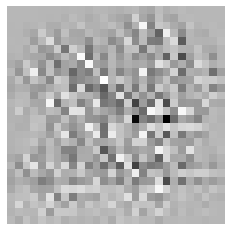

In [74]:
plt.imshow(test, cmap='gray_r')
plt.axis('off')

In [216]:
class GAN():
    
    def __init__(self, real):
        self.BATCH_SIZE = 64
        self.IMG_HEIGHT = 28
        self.IMG_WIDTH = 28
        self.CHANNELS = 1
        
        self.discriminator = self._set_discriminator()
        self.generator = self._set_generator()
        
        self.real = real / 255.
        
        self.discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)
        self.generator_optimizer = tf.keras.optimizers.Adam(0.0005)
        
        
    def _set_discriminator(self):
        

        
        # cnn model
        img_inputs = tf.keras.layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

        x = layers.Conv2D(filters=32, kernel_size=(4,4), input_shape=(28,28,1),
                          activation="relu")(img_inputs)

        x = layers.MaxPool2D(pool_size=(2,2))(x)
        x = layers.Conv2D(filters=32, kernel_size=(2,2),
                          activation="relu")(x)
        x = layers.Dropout(0.2)(x)
        x = layers.MaxPool2D(pool_size=(2,2))(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(units=1, activation="sigmoid")(x)

        disc = tf.keras.Model(inputs=img_inputs, outputs=outputs, name='disc')
        
        return disc
    
    def _set_generator(self):
        
        # https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose?version=stable
        noise_inputs = tf.keras.Input(shape=100)
        x = layers.Dense(100, activation="relu")(noise_inputs)
        x = layers.Reshape(target_shape=(10,10,1))(x)
        x = layers.Conv2DTranspose(filters=5, kernel_size=(3,3), strides=(2,2))(x)
        x = layers.Conv2DTranspose(filters=5, kernel_size=(3,3), strides=(1,1))(x)
        outputs = layers.Conv2DTranspose(filters=1, kernel_size=(6,6), strides=(1,1))(x)
        gen = tf.keras.Model(inputs=noise_inputs, outputs=outputs, name='mnist_model')   

        return gen
    
    def noise_vector(self, features, size=1):
        return np.array([np.random.uniform(size=features) for i in range(size)])
    
    def show_image(self, img_array):
        plt.imshow(img_array, cmap='gray_r')
        plt.axis('off')
        
    def compile_models(self):
        self.discriminator.compile(loss="binary_crossentropy",
              optimizer=self.discriminator_optimizer,
              metrics=['accuracy'])
        #self.generator.compile()

        
    def train_discriminator(self, real_img_array, fake_img_array):
        
        # reshape real
        real_img_array = np.expand_dims(real_img_array,-1)

        #print(real_img_array.shape)
        #print(fake_img_array.shape)
        
        X = np.concatenate((real_img_array, fake_img_array))
        y_real = np.repeat(1, repeats=len(real_img_array))
        y_fake = np.repeat(0, repeats=len(fake_img_array))
        y = np.concatenate((y_real, y_fake))
        
        #print(X.shape)
        #print(y.shape)
        
        X_data = tf.data.Dataset.from_tensor_slices(X)
        y_data = tf.data.Dataset.from_tensor_slices(y)
        
        disc = ut.CustomTraining(model=self.discriminator,
                                 optimizer=self.discriminator_optimizer,
                                loss = ut.losses.BinaryCrossentropy(from_logits=True))
        
        disc.fit(X_data, y_data, model_params=False, each=1)
        
        self.discriminator = disc.model
    
    def generator_loss(self,y_true, y_pred):
        ## infinite loss
        loss = ut.losses.BinaryCrossentropy(from_logits=True)
        return loss
    
    def freeze_weights(self, model):
        for layer in model.layers:
            layer.trainable = False
    
    def unfreeze_weights(self, model):
        for layer in model.layers:
            layer.trainable = True
          
    def train_generator(self, fake_data):
        
        # freeze disc
        y_true = tf.data.Dataset.from_tensor_slices(np.repeat(1, repeats=len(fake_data)))
        X_data = tf.data.Dataset.from_tensor_slices(fake_data)
        #X_fake = self.gen.predict(X_data) 
        y_pred = self.discriminator.predict(X_data.batch(self.BATCH_SIZE))
        
        print(y_true)
        print(y_pred)
        
        
        #am.fit(fake_data, np.repeat(1, repeats=len(fake_data)), validation_split=0.2, batch_size=self.BATCH_SIZE)
        #fake_img_array = self.generator.predict(fake_data)
        #y_pred_proba = np.squeeze(self.discriminator.predict(fake_img_array))
        ##loss = self.generator_loss(y_pred_proba)
        #updates_op = self.optimizer.get_updates(params=self.generator.trainable_weights, loss=self.generator_loss(y_pred_proba))
        return am
    
    def fit(self, epochs=10):
        for i in range(epochs):
            
            # train discriminator
            fake_data = self.noise_vector(features=100,size=len(self.real))
            #fake_data = np.expand_dims(fake_data,-1)
            #print(fake_data.shape)
            X_fake = self.generator.predict(fake_data)
            
            #print(self.real.shape)
            #print(X_fake.shape)
            
            #self.train_discriminator(self.real, X_fake)
            
            
            # train generator
            self.train_generator(X_fake)
            
    

In [217]:
gan = GAN(real=X_train[:100])

In [218]:
gan.compile_models()

In [219]:
#gan.discriminator.summary()

In [220]:
#gan.generator.summary()

In [221]:
gan.fit()

<TensorSliceDataset shapes: (), types: tf.int64>
[[0.5005115 ]
 [0.50809383]
 [0.50647765]
 [0.5069373 ]
 [0.5039633 ]
 [0.50703275]
 [0.5128284 ]
 [0.50865483]
 [0.50465137]
 [0.50920355]
 [0.5056313 ]
 [0.51247877]
 [0.50813144]
 [0.50764084]
 [0.5067946 ]
 [0.51481384]
 [0.5015429 ]
 [0.507535  ]
 [0.51407015]
 [0.5076521 ]
 [0.5075105 ]
 [0.50592303]
 [0.5075422 ]
 [0.51167506]
 [0.51001555]
 [0.51111794]
 [0.5096908 ]
 [0.5095634 ]
 [0.5115201 ]
 [0.50688684]
 [0.50825953]
 [0.5093751 ]
 [0.512114  ]
 [0.5104637 ]
 [0.5106715 ]
 [0.51082784]
 [0.5111838 ]
 [0.50461483]
 [0.5109496 ]
 [0.5114009 ]
 [0.5094931 ]
 [0.50864047]
 [0.50988835]
 [0.50775933]
 [0.5062943 ]
 [0.50705886]
 [0.5068952 ]
 [0.5088107 ]
 [0.50963444]
 [0.51179606]
 [0.50713176]
 [0.50471324]
 [0.50419605]
 [0.50096667]
 [0.50991625]
 [0.50330997]
 [0.5152278 ]
 [0.5063228 ]
 [0.5080695 ]
 [0.51203626]
 [0.508572  ]
 [0.5069909 ]
 [0.50946903]
 [0.5073473 ]
 [0.5070332 ]
 [0.5068603 ]
 [0.5056703 ]
 [0.50925577]

In [918]:
gan.generator

In [505]:
gan.generator_loss(0,np.array([0.1,0.1,0.9,0.9]))

<tf.Tensor: shape=(), dtype=float64, numpy=-4.8158912173037445>

In [506]:
gan.compile_models()

In [507]:
#gan.generator.trainable_weights

In [758]:
gan.train_generator().summary()

Train on 12800 samples, validate on 3200 samples
12800/12800 [==============================] - 6s 443us/sample - loss: 2.1148 - accuracy: 0.0025 - val_loss: 2.0796 - val_accuracy: 3.1250e-04
Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mnist_generator (Model)      (32, 28, 28, 1)           461       
_________________________________________________________________
mnist_discriminator (Model)  (32, 1)                   645       
Total params: 1,106
Trainable params: 461
Non-trainable params: 645
_________________________________________________________________


In [759]:
gan.generator.summary()

Model: "mnist_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_165 (InputLayer)       [(32, 100, 1)]            0         
_________________________________________________________________
reshape_124 (Reshape)        (32, 10, 10, 1)           0         
_________________________________________________________________
conv2d_transpose_253 (Conv2D (32, 21, 21, 5)           50        
_________________________________________________________________
conv2d_transpose_254 (Conv2D (32, 23, 23, 5)           230       
_________________________________________________________________
conv2d_transpose_255 (Conv2D (32, 28, 28, 1)           181       
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [480]:
gan.compile_models()

In [481]:
gan.train_discriminator()

TypeError: train_discriminator() missing 2 required positional arguments: 'real_img_array' and 'fake_img_array'

In [748]:
X_fake = gan.noise_vector(features=100, size=12000)

In [749]:
X_fake.shape

(12000, 100)

In [870]:
fake = gan.generator.predict(np.expand_dims(X_fake,-1))
fake.shape

(12000, 28, 28, 1)

In [871]:
#gan.train_generator(X_fake)

In [872]:
np.squeeze(fake[0]).shape
img_array = np.squeeze(fake[10])
img_array.shape

(28, 28)

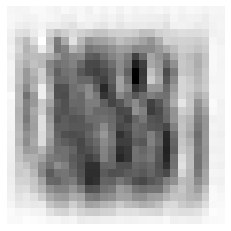

In [873]:
gan.show_image(img_array)

In [874]:
gan.discriminator.predict(fake)

array([[0.99975353],
       [0.9995646 ],
       [0.99963963],
       ...,
       [0.99988246],
       [0.9997265 ],
       [0.99931383]], dtype=float32)

In [875]:
gan.discriminator(np.expand_dims(gan.real,-1))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(60000, 1), dtype=float32, numpy=
array([[0.9999076 ],
       [0.99998903],
       [0.8505106 ],
       ...,
       [0.9990171 ],
       [0.99846363],
       [0.9983368 ]], dtype=float32)>

In [489]:
gan.train_discriminator(gan.real, fake)

(60000, 28, 28, 1)
(12000, 28, 28, 1)
(72000, 28, 28, 1)
(72000,)
Train on 57600 samples, validate on 14400 samples
57600/57600 [==============================] - 17s 302us/sample - loss: 5.5199e-08 - accuracy: 1.0000 - val_loss: 0.6836 - val_accuracy: 0.1667
